In [1]:
from __future__ import (absolute_import, print_function, division)
import numba #jit to make code faster
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
import os
from scipy.stats import dirichlet
import numpy as np
import scipy
from np.random import normal as rnorm
from numpy import diag
from numpy import trace as tr
from numpy.random import random as rand
from numpy.linalg import inv
from scipy.stats import multivariate_normal.pdf as mvarnorm
from scipy.stats import multivariate_normal as mvn
from scipy import stats
from scipy.stats import wishart
from scipy.stats import norm
from stats.dirichlet import entropy as direntropy
from numpy.linalg import inv
from numpy import log as ln
from scipy.special import psi
from numpy.linalg import det
from np import log as ln
from scipy.special import psi
from scipy.special import gammaln


%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


Different than EM, variational inference introduces priors on model variables (local and global)

Wishart Distribution
-----
scipy.stats.wishart

scipy.stats.wishart = <scipy.stats._multivariate.wishart_gen object at 0x4522576c>[source]
A Wishart random variable.

The df keyword specifies the degrees of freedom. The scale keyword specifies the scale matrix, which must be symmetric and positive definite. In this context, the scale matrix is often interpreted in terms of a multivariate normal precision matrix (the inverse of the covariance matrix).

Parameters:	
x : array_like
Quantiles, with the last axis of x denoting the components.
df : int
Degrees of freedom, must be greater than or equal to dimension of the scale matrix
scale : array_like
Symmetric positive definite scale matrix of the distribution
random_state : None or int or np.random.RandomState instance, optional
If int or RandomState, use it for drawing the random variates. If None (or np.random), the global np.random state is used. Default is None.
Alternatively, the object may be called (as a function) to fix the degrees
of freedom and scale parameters, returning a “frozen” Wishart random
variable:
rv = wishart(df=1, scale=1)
Frozen object with the same methods but holding the given degrees of freedom and scale fixed.

Notes

The scale matrix scale must be a symmetric positive definite matrix. Singular matrices, including the symmetric positive semi-definite case, are not supported.

The Wishart distribution is often denoted

Wp(ν,Σ)
where ν is the degrees of freedom and Σ is the p×p scale matrix.

The probability density function for wishart has support over positive definite matrices S; if S∼Wp(ν,Σ), then its PDF is given by:

$f(S)=|S|ν−p−122νp2|Σ|ν2Γp(ν2)exp(−tr(Σ−1S)/2)$
If $S∼Wp(ν,Σ)$ (Wishart) then S−1∼W−1p(ν,Σ−1) (inverse Wishart).

If the scale matrix is 1-dimensional and equal to one, then the Wishart distribution W1(ν,1) collapses to the χ2(ν) distribution.

New in version 0.16.0.


Dirichlet Distribution
-------
scipy.stats.dirichlet = <scipy.stats._multivariate.dirichlet_gen object at 0x452255cc>[source]
A Dirichlet random variable.

The alpha keyword specifies the concentration parameters of the distribution.

New in version 0.15.0.

Parameters:	
x : array_like
Quantiles, with the last axis of x denoting the components.
alpha : array_like
The concentration parameters. The number of entries determines the dimensionality of the distribution.
random_state : None or int or np.random.RandomState instance, optional
If int or RandomState, use it for drawing the random variates. If None (or np.random), the global np.random state is used. Default is None.
Alternatively, the object may be called (as a function) to fix
concentration parameters, returning a “frozen” Dirichlet
random variable:
rv = dirichlet(alpha)
Frozen object with the same methods but holding the given concentration parameters fixed.
Each α entry must be positive. The distribution has only support on the simplex defined by

$∑i=1Kxi≤1
The probability density function for dirichlet is f(x)=1B(α)∏i=1Kxαi−1i
where (α)=∏Ki=1Γ(αi)Γ(∑Ki=1αi)
and α=(α1,…,αK), the concentration parameters and K is the dimension of the space where x takes values.$




From discussion on Wishart
---
* $E[\Lambda] = aB^{-1}$ 
* $E[ln|\Lambda|] = d(d-1)/4 * ln(\pi) + d ln(2) - ln|B| + \sum_{{j=1}}^{d}\Psi(\alpha/2+(1-j)/2)$

From VI for GMM given distributions
----
* $q(\pi) = Dirichlet(\alpha_1^`, ..., \alpha_K^`)$
* $q(\mu_j) = Normal(m_j^`,\sum_j^`)$
* $q(\Lambda_j) = Wishart(\alpha_j^`, B_j^`)$
* $q(c_i) = Multinomial(\phi_i)$

The indices indicate the iterative dependence I am going to implement as a part of VI for GMM.

In [2]:
wpdf = wishart.pdf
dirpdf = dirichlet.logpdf

def sample_from_x(x):
    """Yikes, recursive but works for me"""
    tmp1 = scipy.random.choice(x[0],1)
    tmp2 = scipy.random.choice(x[1],1)
    return np.array((tmp1[0],tmp2[0]))

Input:
* Data $x_1, x_2, ..., x_n$ where x $\epsilon R^d$
* k is the number of clusters as in GMM
Output:
* Parameters for $q(\pi), q(\mu_j), q(\Lambda_j), q(c_i)$ 

VI Algorithm for Gaussian Mixture Model
------
1. Initialize $\alpha_1^{(0)}, ...., \alpha_k^{(0)}) , (m_j^{(0)}, \sum_j^{(0)}), (\alpha_j^{(0)}, B_j^{(0)})$ in some way.
2. At iteration t:
    * Update $q(c_i)$ for i=1, ..., n
    * For j = 1, ...., K Set $n_j^{(t)}=\sum_{j=1}^{d} \phi_i^{t}(j)$
    * For j = 1, ..., K 
        * Update $q(\pi)$ by setting $\alpha_j^{(t)} = \alpha + n_j^{(t)}$
    * For j = 1, ...., K
        * Update $q(\mu_j)$:
            
            * $\sum_j^{(t)}$=$(c^{-1}I+n_j^{(t)}\alpha_j^{(t-1)}(B_j^{(t-1)}))^{-1}$
            * $m_j^{(t)}=\sum_j^{(t)}(\alpha_j^{(t-1)}(B_j^{(t-1)})^{-1}\sum_{{i=1}}^{d}\phi^{t}(j)x_i)$
    * For j = 1, ..., K
        * Update $q(\Lambda_j)$:
            
            * $\alpha_j^{(t)} = \alpha + n_j^{(t)}$
            * $B_j^{(t)}=B+\sum_i^{n}\phi_i^{(t)}(j)[(x_i-m_j^{(t})(x_i-m_j^{(t})^{T} + \sum_j^{(t)}]$
    * And lastly, calculate variation inference objective function L

As one can see above, there are two major loops, 1 to T for iterations in order to update and 1 to K for j. 

Step 2
------
**Part a**

$L = E[ln p(x, c, \pi, \mu, \Lambda)] - E[ln q]$

$L = E[ln p(x|c, \pi, \mu, \Lambda] + E[ln p(c|\pi] - E[ln q]$

$ E[ln p(x|c, \pi, \mu, \Lambda)]$ will be $\mu_i$

$ x_i|c_i ~ Normal(\mu_c \Lambda_c)$

$x_i ∼ p(x|π, µ, Λ) = \sum_{j=1}^{K}  π_j  Normal(x|µj)$
SInce $\pi, \mu, \Lambda$ are independent 



In [5]:
def gmm_vi(x_train,K,T):    
	"""Implementation of Variation inference gaussian mixture algorithm """
    # Initialization Step 1
    np.random.seed(1)
    n, d = x_train.shape
    alpha = 1.0
    c = 10.0
    a = float(d) 
    n_j = np.ones(K)
    a_j = rand(K) * 10
    mu_j_j = [rand((d,d)) for i in range(K)]
    m_j = [ sample_from_x(x_train) for i in range(K)]
    alpha_k = rand(K) * 10
    B = (d /10.0)* np.cov(x_train.T)
    B_j = [diag(diag(B)) * rand(1) for i in range(K)]
    t1_j = np.zeros((n,K))
    t2_j = np.zeros((n,K))
    t3_j = np.zeros((n,K))
    t4_j = np.zeros((n,K))
    phi_ij = np.ones((n,K)) * (1.0/K)
    c_i = diag([float(1/c)]*d)
    my_var_obj = np.zeros(T)
    for t in range(T):
        for i, xi in enumerate(x_train.values):
            # Step 2, part a
            for j in range(K): 
                x_m_diff = (xi - m_j[j]).reshape((d,1))
                t1_j[i,j] = np.sum([psi( (float(k) + a_j[j])/2.0 ) for k in range(d)]) - ln(det(B_j[j]))
                t2_j[i,j] = x_m_diff.T.dot( ( a_j[j]* inv(B_j[j]) ) ).dot(x_m_diff)
                t3_j[i,j] = tr((a_j[j]*inv(B_j[j])).dot(mu_j_j[j]) )
                t4_j[i,j] = psi( alpha_k[j] ) - psi( np.sum(alpha_k) )
        phi_num = np.zeros((n,K))
        denum_phi = np.zeros((n,1))
        for j in range(K):
            phi_num[:,j] = np.exp( 0.5*t1_j[:,j] - 0.5*t2_j[:,j]- 0.5*t3_j[:,j] + t4_j[:,j])    
            denum_phi+= phi_num[:,j].reshape((n,1))
        # finally, given all ts calculate phi(j) as in the algorithm
        phi_ij = np.divide(phi_num ,denum_phi)
        # Step 2, part b
        for j in range(K):
            n_j[j] = np.sum(phi_ij[:,j])
            # Step 2, (c)
            alpha_k[j] = alpha + n_j[j]
            # Step 2, (d)
            mu_j_j[j] = inv( c_i + (n_j[j]*a_j[j]) * inv(B_j[j]))   
            m_j[j] = mu_j_j[j].dot( a_j[j]* inv(B_j[j]).dot( np.sum(phi_ij[:,j].reshape(n,1) * x_train))  )
        # Step 2, (e)
        for j in range(K):
            all_bs = 0
            for i, xi in enumerate(x_train.values):
                x_m_diff = (xi-m_j[j]).reshape((d,1))
                all_bs += phi_ij[i,j] * (x_m_diff.dot(x_m_diff.T) + mu_j_j[j])
            B_j[j] = B + all_bs
            a_j[j] = a + n_j[j]
        # Step 2 (f), Calculate variational objective function
        expectat_log_qpi = direntropy(alpha_k)
        expectat_log_qmu  = [stats.multivariate_normal.entropy(m_j[j],mu_j_j[j]) for j in range(K)]
        expectat_log_qLambda = [stats.wishart.entropy(a_j[j], inv(B_j[j])) for j in range(K)]
        expectat_log__pi = (alpha-1.0) * (psi(alpha_k)-psi(np.sum(alpha_k)))
        expectat_log_pmu = -0.5 / c * np.asarray([np.trace(mu_j_j[j])+m_j[j].dot(m_j[j]) for j in range(K)])
        expectat_log_Lambda = -np.log(det(B_j))+np.sum(psi((a_j.reshape(K, 1)+1.0-np.arange(1, d+1)) / 2.0),1)
        expectat_log_pi = psi(alpha_k)-psi(np.sum(alpha_k))
        exp_x_given_lambdamu = np.zeros((n,K))
        for i, xi in enumerate(x_train.values):
             for j in range(K):
                x_i_m_j_diff = (xi-m_j[j]).reshape(d,1)
                exp_x_given_lambdamu[i,j] = x_i_m_j_diff.T.dot(a_j[j]*inv(B_j[j])).dot(x_i_m_j_diff)+np.trace(a_j[j]*inv(B_j[j]).dot(mu_j_j[j]))
        expectat_log_pLambda = np.multiply(a_j-d-1.0,expectat_log_Lambda)/2.0-0.5*np.asarray([np.trace(B_j[j].dot(a_j[j]*inv(B_j[j]))) for j in range(K)])
        expectat_log_pxc = np.sum(np.multiply(phi_ij,0.5*expectat_log_Lambda+expectat_log_pi-0.5*exp_x_given_lambdamu),0)
        L = sum(expectat_log__pi)+sum(expectat_log_pmu)+sum(expectat_log_pxc)+sum(expectat_log_pLambda)-expectat_log_qpi-sum(expectat_log_qmu)-sum(expectat_log_qLambda)
        my_var_obj[t]=L
    return phi_ij, m_j, mu_j_j, alpha_k, a_j, B_j, my_var_obj

def vi_gmm_scatplot(phi_ij, x_train, k):
    cluster = [i.argmax() for i in phi_ij]
    myplot = plt.figure(figsize=(14,14))
    plt.scatter(x_train[0].values,x_train[1].values,c=cluster,s=100)
    plt.title('Scatter plot for VI Gaussian Mixture Model with K='+str(k))
    plt.show()

def var_obj_plot(my_var_obj,k):
    myplot = plt.figure(figsize=(14,14))
    plt.plot(my_var_obj)
    plt.title('Variational Objective Function Gaussian mixture K='+str(k))
    plt.show()

**Part b and c**

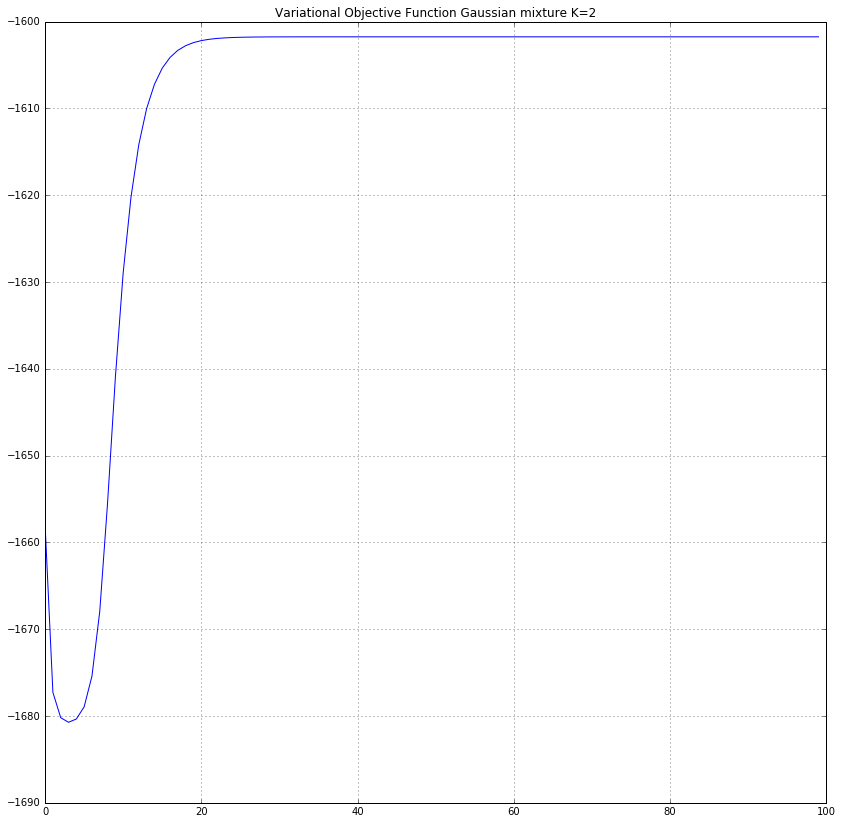

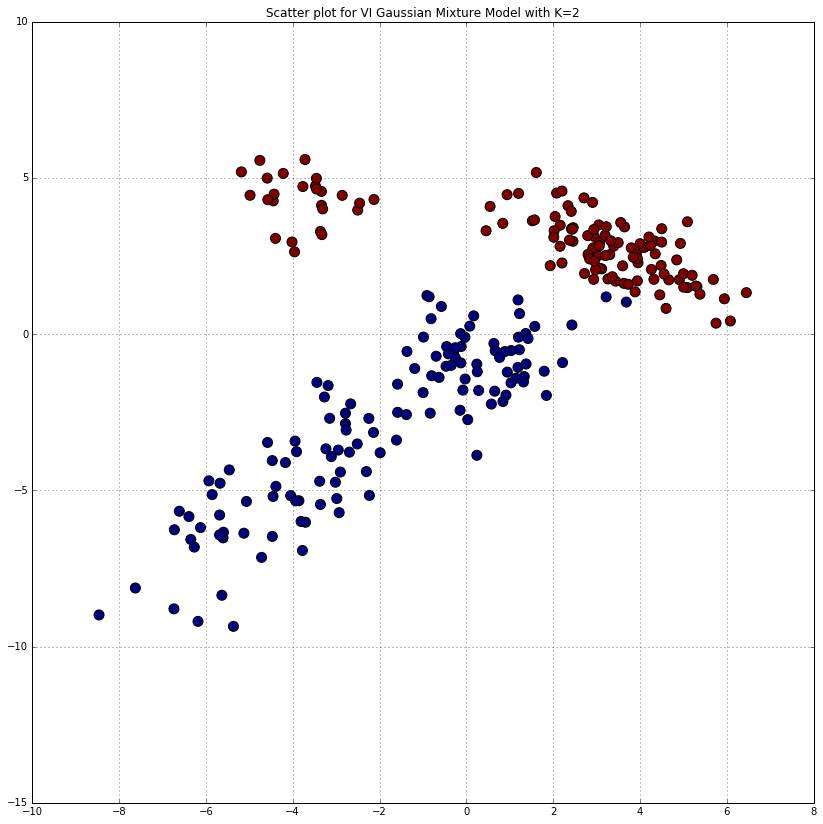

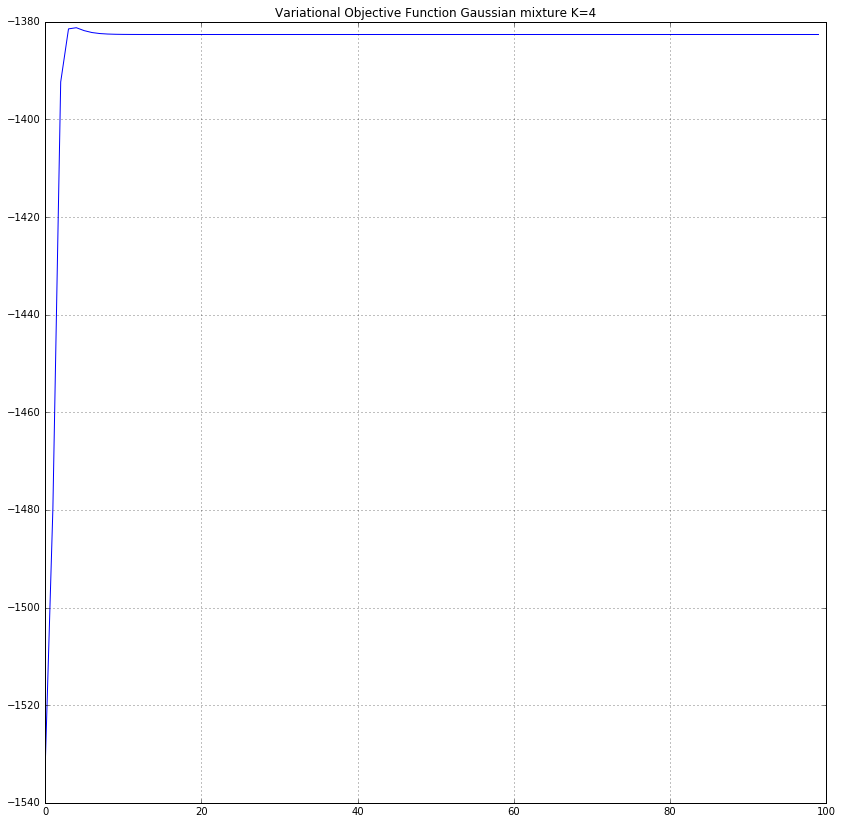

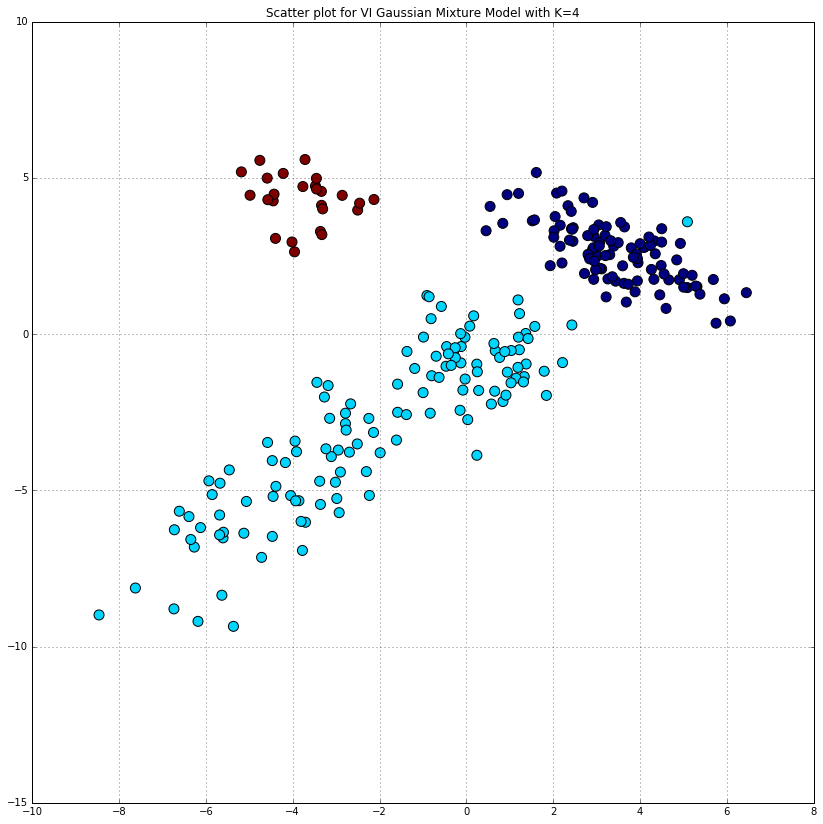

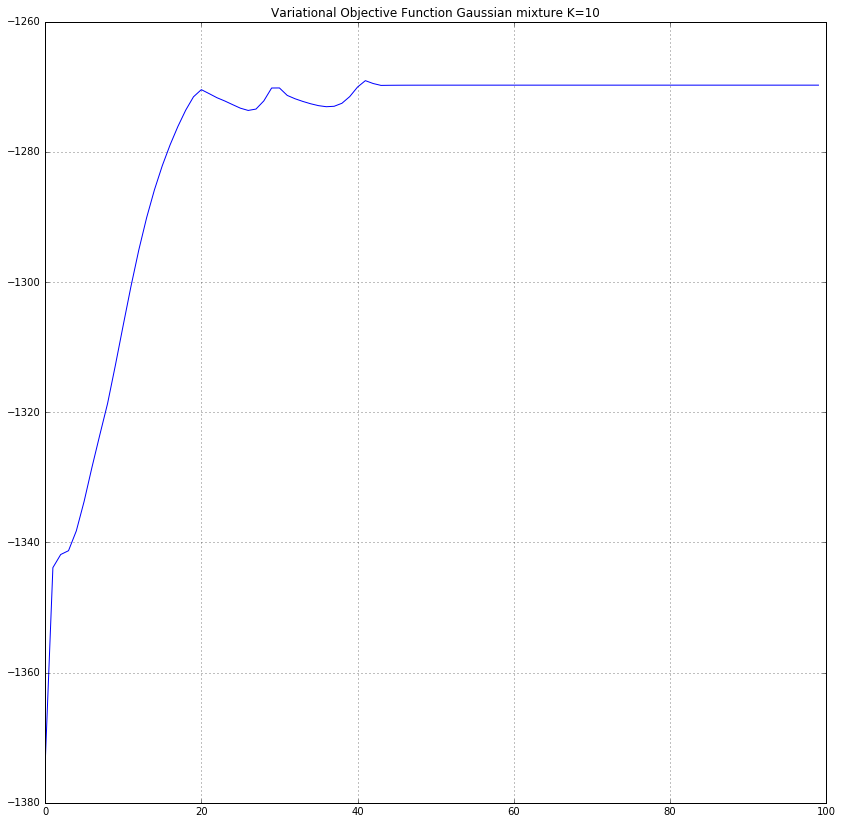

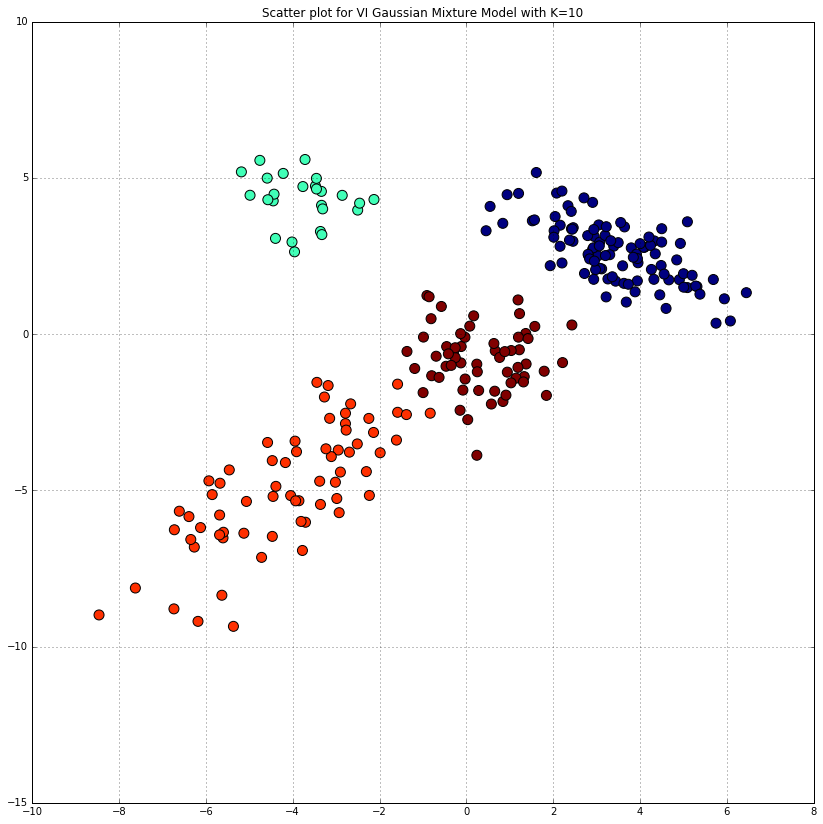

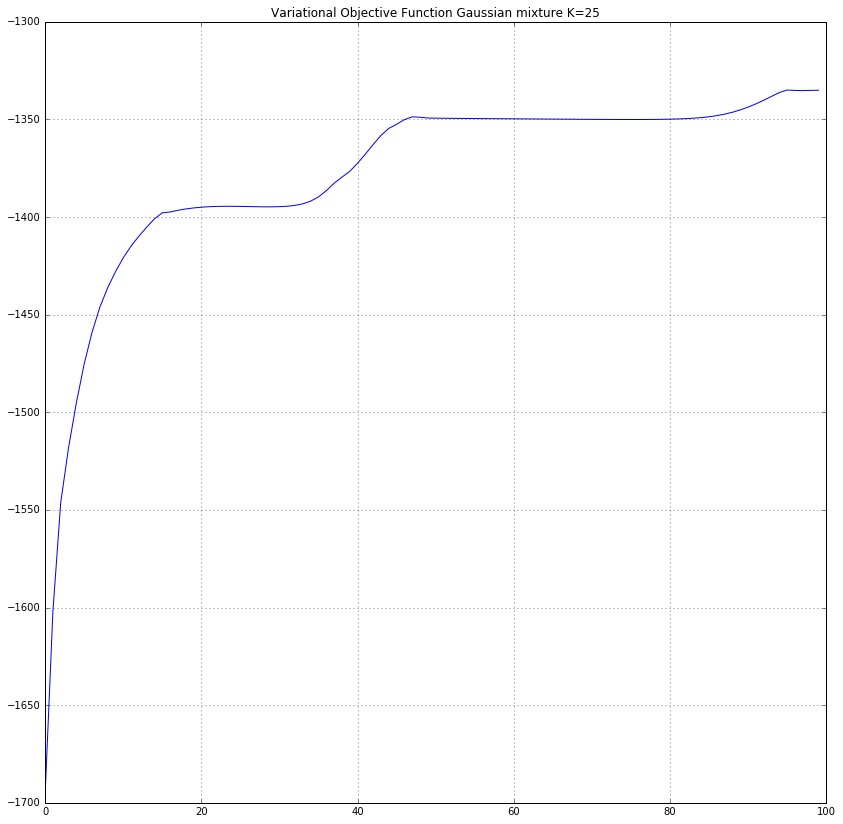

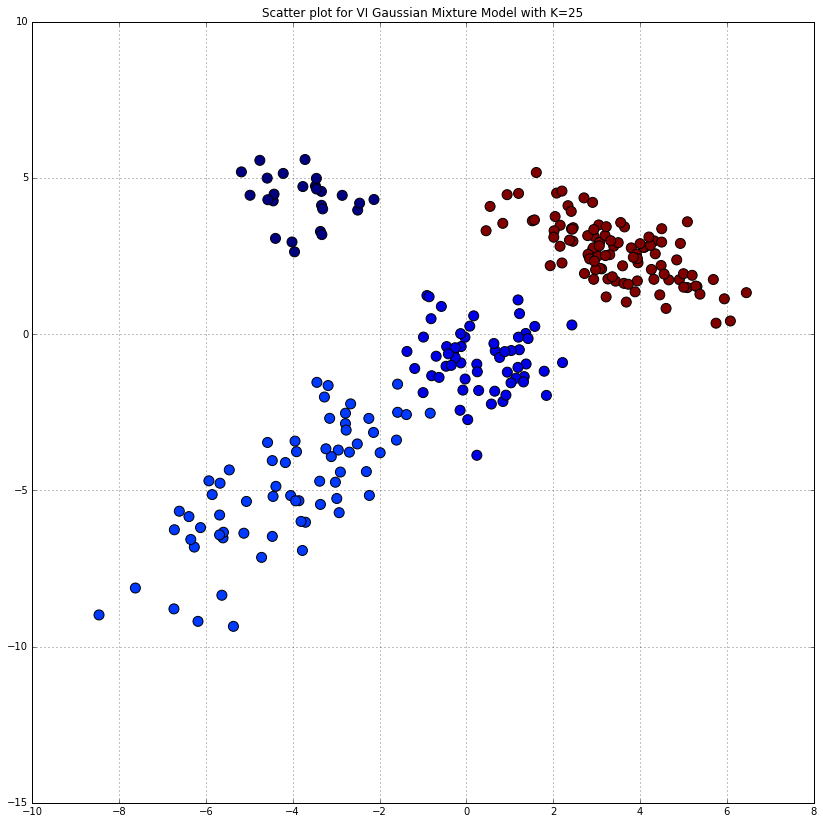

In [7]:
os.chdir('/Users/arkilic/Desktop/')
xtrn =pd.read_csv('data.txt', header=None)
xtrn =pd.read_csv(inpth+'data.txt',header=None)
var_inf_gmm_res= {}
for k in (2,4,10,25):
    vigmm = "vigmm%d" % k 
    var_inf_gmm_res[vigmm]= gmm_vi(xtrn,k,100)
    var_obj_plot(var_inf_gmm_res[vigmm][6],k)
    vi_gmm_scatplot(var_inf_gmm_res[vigmm][0],xtrn,k)
    

_As K increases, the variational objective function does not converge as fast. This is apparent looking at the plots above. Also, the distinct data points provided do not occupy cluster count K. This makes sense as in the lecture Dr Paisley suggested this was a feature of Bayesian Variation Inference on GMM (or other conjugate exponential family mixture). In other words, I observe 4 clusters that data is most probably contained within given there are 10 clusters (in case of K=10)._